In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Import libraries for optimization
import scipy
from scipy import stats
from scipy.optimize import brentq, least_squares

# Import WRDS library
import wrds

## Accessing the WRDS database

In order to access the WRDS database, one needs to have an account and a subscription to the relevant databases.
Some universities may have existing subscriptions which students can use.

In [2]:
# Establish live connection; requires user login (passwords will be masked)
db = wrds.Connection()

# Show list of available libraries
lib = db.list_libraries()
om = [x for x in lib if 'option' in x]
om

Enter your WRDS username [leeca]:cadenlee
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time
with the create_pgpass_file() function.
Loading library list...
Done


['optionm',
 'optionm_all',
 'optionmsamp_europe',
 'optionmsamp_us',
 'wrdsapps_link_crsp_optionm']

Here, I will looking at `optionm_all` database, which consists of US equity options

In [3]:
# Enquire existing available data tables
tables = db.list_tables(library='optionm_all')
print('There exists {} tables within the optionm_all library.'.format(len(tables)))
tables[0:5]

There exists 208 tables within the optionm_all library.


['distrd',
 'distrprojd1996',
 'distrprojd1997',
 'distrprojd1998',
 'distrprojd1999']

One can further explore the available datasets within the library. There exists security price data, option price data, zero curve, historical volatility surface etc.

Here, I identified three key tables that I need for the demonstration:
1. `optionnames`: reference data
2. `opprcd2023`: daily option price data for year 2023
3. `zerocd`: zero curve data (for zero rates)

Below describes the attributes for the respective tables.

In [4]:
db.describe_table(library='optionm_all', table='optionmnames')

Approximately 53758056 rows in optionm_all.optionmnames.


,name,nullable,type,comment
0,secid,True,DOUBLE_PRECISION,None
1,symbol,True,VARCHAR(21),None
2,optionid,True,DOUBLE_PRECISION,None
3,root,True,VARCHAR(5),None
4,suffix,True,VARCHAR(2),None
5,effect_date,True,DATE,None
6,cusip,True,VARCHAR(8),None
7,ticker,True,VARCHAR(6),None
8,class,True,VARCHAR(1),None
9,issuer,True,VARCHAR(28),None


In [5]:
db.describe_table(library='optionm_all', table='opprcd2023')

Approximately 54202464 rows in optionm_all.opprcd2023.


,name,nullable,type,comment
0,secid,True,DOUBLE_PRECISION,None
1,date,True,DATE,None
2,symbol,True,VARCHAR(21),None
3,symbol_flag,True,VARCHAR(1),None
4,exdate,True,DATE,None
5,last_date,True,DATE,None
6,cp_flag,True,VARCHAR(1),None
7,strike_price,True,DOUBLE_PRECISION,None
8,best_bid,True,DOUBLE_PRECISION,None
9,best_offer,True,DOUBLE_PRECISION,None


In [6]:
db.describe_table(library='optionm_all', table='zerocd')

Approximately 297212 rows in optionm_all.zerocd.


,name,nullable,type,comment
0,date,True,DATE,None
1,days,True,DOUBLE_PRECISION,None
2,rate,True,DOUBLE_PRECISION,None


In [7]:
db.describe_table(library='optionm_all', table='secprd2023')

Approximately 392616 rows in optionm_all.secprd2023.


,name,nullable,type,comment
0,secid,True,DOUBLE_PRECISION,None
1,date,True,DATE,None
2,low,True,DOUBLE_PRECISION,None
3,high,True,DOUBLE_PRECISION,None
4,close,True,DOUBLE_PRECISION,None
5,volume,True,DOUBLE_PRECISION,None
6,return,True,DOUBLE_PRECISION,None
7,cfadj,True,DOUBLE_PRECISION,None
8,open,True,DOUBLE_PRECISION,None
9,cfret,True,DOUBLE_PRECISION,None


## Constructing query script 

The query language used is the Standard Query Language (SQL), thus it is fairly easy to work with.
Depending on the size of the data, the query time can be rather long. It is crucial to optimize the query script to minimize run time.

In [8]:
# date of query = 2020/12/01
# Exipry date = 2021/12/17
# secid = 108105 for SPX

option_query = '''
SELECT 
    A.symbol,
    A.date,
    A.exdate,
    A.cp_flag,
    A.strike_price,
    A.impl_volatility
    
FROM optionm_all.opprcd2020 A

WHERE A.secid = 108105
    AND A.date = TO_DATE('2020/12/01', 'YYYY/MM/DD')
    AND A.exdate = TO_DATE('2021/12/17', 'YYYY/MM/DD') 
'''

zero_curve_query = '''
SELECT *
FROM optionm_all.zerocd A
WHERE A.date = TO_DATE('2020/12/01', 'YYYY/MM/DD')
'''

close_price_query = '''
SELECT
    A.date,
    A.close
    
FROM optionm_all.secprd2020 A
WHERE A.secid = 108105
AND A.date = TO_DATE('2020/12/01', 'YYYY/MM/DD')
'''

In [9]:
spx = db.raw_sql(close_price_query, date_cols=['A.date'])
spx

,date,close
0,2020-12-01,3662.45


In [10]:
spx_opt = db.raw_sql(option_query, date_cols=['A.date'])
print(spx_opt.shape)
spx_opt.head()

(290, 6)


,symbol,date,exdate,cp_flag,strike_price,impl_volatility
0,SPX 211217C100000,2020-12-01,2021-12-17,C,100000.0,1.656112
1,SPX 211217C1000000,2020-12-01,2021-12-17,C,1000000.0,0.638971
2,SPX 211217C1100000,2020-12-01,2021-12-17,C,1100000.0,0.603071
3,SPX 211217C1150000,2020-12-01,2021-12-17,C,1150000.0,0.586485
4,SPX 211217C1200000,2020-12-01,2021-12-17,C,1200000.0,0.570427


In [11]:
zero_curve = db.raw_sql(zero_curve_query, date_cols=['A.date'])

zero_curve.head()

,date,days,rate
0,2020-12-01,7.0,0.102280
1,2020-12-01,13.0,0.114128
2,2020-12-01,49.0,0.216480
3,2020-12-01,77.0,0.220707
4,2020-12-01,104.0,0.219996


## Run Option Volatility Smile Calibration

Here, we shall attempt to fit the volatility smile of a far-dated option using the Displaced-Diffusion Model.

For the full concept of the Displaced-Diffusion Model, please refer to `02_1_Option Smile Calibration using Displaced-diffusion.ipynb`.

Contract:
- SPX Option 20211217 Expiry
- Query Date 20201201


In [12]:
# Get spot price
spx_spot = spx.close.values[0]

# Get the key dates
ex_date = spx_opt.exdate.unique()[0]
spot_date = spx_opt.date.unique()[0]

In [13]:
def get_AOTM_options(x, spot):
    if x['cp_flag'] == 'C':
        return True if x['strike_price'] >= spot else False
    else:
        return True if x['strike_price'] <= spot else False

In [14]:

spx_opt['strike_price'] *= 0.001
spx_opt['AOTM'] = spx_opt.apply(lambda x: get_AOTM_options(x, spx_spot), axis = 1)

# Get days to expiry
spx_opt['days_to_expiry'] = (pd.to_datetime(spx_opt.exdate, format = '%Y-%m-%d')-\
                                pd.to_datetime(spx_opt.date, format = '%Y-%m-%d')).dt.days

print('The days to expiry of the contracts is', spx_opt['days_to_expiry'].unique()[0])

The days to expiry of the contracts is 381


In [15]:
# Attempt to interpolate discount factors for the days to maturity of concern
xp = zero_curve['days'].to_numpy()
fp = zero_curve['rate'].to_numpy()/100
days_to_expiry = spx_opt['days_to_expiry'].unique()[0]
required_zero_rate = np.interp(days_to_expiry, xp, fp)

# Print out the zero rate given days to expiry
print('The zero rate: {:.4f}%'.format(required_zero_rate*100))

The zero rate: 0.2145%


In [16]:
# Calculate required variables for implied vol calculation
spx_opt = spx_opt[spx_opt['AOTM'] == True]
spx_opt = spx_opt.reset_index(drop = True)

spx_opt = spx_opt.sort_values(by = 'strike_price')
ATM_vol_plus = spx_opt[spx_opt['strike_price']>spx_spot]['impl_volatility'].iloc[0]
ATM_vol_minus = spx_opt[spx_opt['strike_price']<spx_spot]['impl_volatility'].iloc[-1]

ATM_vol = 0.5*(ATM_vol_plus + ATM_vol_minus)

In [17]:
def black_scholes_option_pricer(S, K, r, T, sigma, call = True):
    '''
    Function calculates option prices based on Black-scholes model.
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*T)/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    if not call:
        d2 = -d2
        d1 = -d1

    option_values = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return option_values

In [18]:
def displaced_diffusion_option_pricer(F, K, r, T, sigma, beta, call):
    ''' 
    Function calculates option prices based on Displaced-Diffusion Model.
    Three modes available: Vanilla (default), Cash-or-Nothing (CON), Asset-or-Nothing (AON)
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: short rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    beta: parameter to adjust degree of "mixture" between geometric and arithmetic BM
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    # Calculate d1 and d2
    d2 = (np.log(F/(beta*(K+(1-beta)/beta*F))) - (np.square(beta*sigma)*T)/2)/(beta*sigma * np.sqrt(T))
    d1 = d2 + sigma*beta*np.sqrt(T)

    #initializing d1 & d2 for call and put
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1

    #calculating the option values
    option_values = F/beta*scipy.stats.norm.cdf(d1) - (K+(1-beta)/beta*F)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return np.exp(-r*T)*option_values

In [19]:
def displaced_diffusion_calibration(x, strikes, cp_flag, vols, F, r, T, vol_atm, weights = np.empty(0)):
    err = 0.0
    
    if not weights.size:
        weights = np.ones(strikes.shape[0])

    for i, K in enumerate(strikes):
        if weights[i]:
            flag = True if cp_flag.iloc[i] == 'C' else False
            dd_price = displaced_diffusion_option_pricer(F, K, r, T, vol_atm, x, call = flag)
            dd_imp_vol = brentq(lambda y: dd_price - black_scholes_option_pricer(F*np.exp(-r*T), K, r, T, y, call = flag),
                                    1e-12, 10.0)
            err += weights[i]*(vols.iloc[i] - dd_imp_vol)**2

    return err

In [20]:
def plotter(df, DD_vols, exdate, underlying):
    plt.figure(figsize = (8,4))

    plt.plot(df['strike_price'], df['impl_volatility'], 'gs', label='Market Vols')
    plt.plot(df['strike_price'], DD_vols, 'm--', label='Displaced-Diffusion Vols')

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title("Implied volatility Smile of {0} options (expiring {1})".format(underlying, exdate))
    plt.legend()
    
    plt.show()

In [21]:
spx_cleaned = spx_opt[['exdate', 'cp_flag','strike_price', 'impl_volatility']].copy()
spx_cleaned

,exdate,cp_flag,strike_price,impl_volatility
34,2021-12-17,P,100.0,0.987853
70,2021-12-17,P,200.0,0.950177
111,2021-12-17,P,300.0,0.849763
139,2021-12-17,P,400.0,0.781035
140,2021-12-17,P,500.0,0.709142
...,...,...,...,...
29,2021-12-17,C,5000.0,0.169841
30,2021-12-17,C,5100.0,0.172308
31,2021-12-17,C,5200.0,0.174934
32,2021-12-17,C,5300.0,0.177090


Calibrated Displaced-Diffusion model parameters: beta = 0.000
The cost of the optimization (half of sum of squares), C =  0.9315899196811578
Plotting...


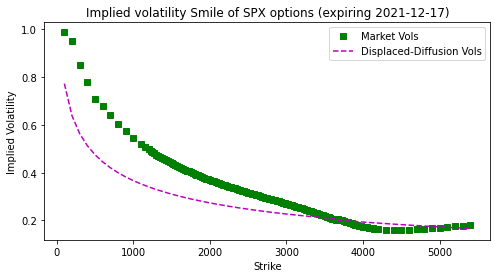

In [22]:
T = days_to_expiry/365
F = spx_spot * np.exp(required_zero_rate * T)

res_dict = {'Expiry': ex_date}

# Initial Guess for model parameter
DD_guess_0 = [0.5]
    
# Calibrate Model to market observed Implied Vol
DD_res = least_squares(lambda x: displaced_diffusion_calibration(x,
                                                                 spx_cleaned['strike_price'],
                                                                 spx_cleaned['cp_flag'],
                                                                 spx_cleaned['impl_volatility'],
                                                                 F,
                                                                 required_zero_rate,
                                                                 T,
                                                                 ATM_vol),
                           DD_guess_0, bounds= (1e-10,1))
    
DD_beta= DD_res.x[0]

print('Calibrated Displaced-Diffusion model parameters: beta = %.3f' % (DD_beta))
print('The cost of the optimization (half of sum of squares), C = ',  DD_res.cost)
    
# Derive implied vol per strike for OTM and ATM options
DD_vols = []
for i, K in enumerate(spx_cleaned['strike_price']):
        flag = True if K > spx_spot else False
        opt_val = displaced_diffusion_option_pricer(spx_spot,
                                                    K, 
                                                    required_zero_rate, 
                                                    T, 
                                                    ATM_vol, 
                                                    DD_beta, 
                                                    call = flag)

        DD_implied_vol = brentq(lambda x: opt_val - black_scholes_option_pricer(spx_spot, 
                                                                                    K, 
                                                                                    required_zero_rate, 
                                                                                    T, 
                                                                                    x, 
                                                                                    call = flag),
                                0.1, 10)
        DD_vols.append(DD_implied_vol)

res_dict['ATM_Vol'] = ATM_vol
res_dict['beta'] = DD_beta

print('Plotting...')
plotter(spx_cleaned,\
        DD_vols,\
        ex_date,\
        'SPX')

Comparing the above results with the previous note, the Displace-diffusion model fits the curve better on the further dated options than the near dated options.

# References

OptionMetrics LLC. (2023). IvyDB: File and Data Reference Manual (Version 5.4, Rev. 03/29/2023) https://wrds-www.wharton.upenn.edu/documents/1504/IvyDB_US_v5.4_Reference_Manual.pdf